# **04. Regression Problem : Using Boston Housing dataset as example**

**Topic**: Using regression to predict the continuous value

### **Step 1: Loading data**

the dataset is included in Keras

In [5]:
from keras.datasets import boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data() 

In [2]:
print("Train data : ",train_data.shape)
print("Train labels : ",train_labels.shape)
print("Test data : ",test_data.shape)
print("Test labels : ",test_labels.shape)

Train data :  (404, 13)
Train labels :  (404,)
Test data :  (102, 13)
Test labels :  (102,)


In [3]:
print(train_data[0])

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]


In [4]:
print(train_labels[0])

15.2


### **Step 2: Perpare the data**

由於我們的 feature 的分佈都不一，有些可能只有 0～1，有些可能 ～無限大，那我們就必須針對所有欄位進行 **Normalization**，使其分佈都以 0 為中心，然後以 std 為單位刻度

#### **data**

In [6]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data = (train_data-mean)/std
test_data = (test_data-mean)/std

### **Step 3: Build Network**

In [7]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add( layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)) )
    model.add( layers.Dense(64, activation='relu') )
    model.add( layers.Dense(1) )
    
    model.compile(optimizer='rmsprop',
                  loss='mse',
                  metrics=['mae'])
    
    return model

這邊的輸出層只有**單一個 Unit**，且**沒有 activation function**，代表輸出為一個 浮點數的數值，也就是**迴歸值**，這是用來做純量回歸的基本設定。

如果我們用 activation function 的話會限制輸出的範圍，例如用 sigmoid 就會限制在 0～1，就不能達到我們想預測房價的目的了

另外這邊所使用的 loss function 為 **mse** (mean squared error)，用來計算 predict 和 label 的差異平方，是迴歸問題常用的函數

metrics 為我們訓練時所監看的數值，它和 loss function 很像，但它並不會影響模型，這邊我們就監看 **mae** (mean absolute error), 用來計算 predict 和 label 的差異絕對值

### **Step 4: Prepare the validation data and fit it to the model**

這次我們訓練的資料與前幾次相比來說較少，那這樣我們的模型就很容易受到訓練資料的影響，那為了避免這狀況發生，通常會使用 **k-fold cross validation** 來進行我們的訓練

![](http://ethen8181.github.io/machine-learning/model_selection/img/kfolds.png)

#### **實作 : 100 epoch**

In [8]:
import numpy as np

k = 4  
num_val_samples = len(train_data)//k
num_epochs = 100
all_scores = []

In [9]:
for i in range(k):
    print("=== Performance # {} ===".format(i))
    
    val_data = train_data[ i*num_val_samples:(i+1)*num_val_samples ]        # prepare the validation data
    val_label = train_labels[ i*num_val_samples:(i+1)*num_val_samples ]
    
    partial_train_data = np.concatenate( [train_data[ :i*num_val_samples ], train_data[ (i+1)*num_val_samples: ]], axis=0 )         # prepare the training data
    partial_train_label = np.concatenate( [train_labels[ :i*num_val_samples ], train_labels[ (i+1)*num_val_samples: ]], axis=0 )
    
    model = build_model()                                   # fit the data to our model
    model.fit(partial_train_data, partial_train_label, 
              epochs = num_epochs,
              batch_size = 1,
              verbose=0)
    
    val_mse, val_mae = model.evaluate(val_data, val_label, verbose=0)
    all_scores.append(val_mae)

=== Performance # 0 ===
=== Performance # 1 ===
=== Performance # 2 ===
=== Performance # 3 ===


In [10]:
all_scores

[2.028413774943588, 2.5212074789670433, 2.62778371395451, 2.5444172856831315]

In [11]:
np.mean(all_scores)

2.4304555633870684

#### **實作 : 500 epoch** ： 並紀錄 History

In [12]:
import numpy as np

k = 4  
num_val_samples = len(train_data)//k
num_epochs = 500
all_mae_history = []

In [14]:
for i in range(k):
    print("=== Performance # {} ===".format(i))
    
    val_data = train_data[ i*num_val_samples:(i+1)*num_val_samples ]        # prepare the validation data
    val_label = train_labels[ i*num_val_samples:(i+1)*num_val_samples ]
    
    partial_train_data = np.concatenate( [train_data[ :i*num_val_samples ], train_data[ (i+1)*num_val_samples: ]], axis=0 )         # prepare the training data
    partial_train_label = np.concatenate( [train_labels[ :i*num_val_samples ], train_labels[ (i+1)*num_val_samples: ]], axis=0 )
    
    model = build_model()                                   # fit the data to our model
    history = model.fit(partial_train_data, partial_train_label,
                        validation_data = (val_data,val_label),
                        epochs = num_epochs,
                        batch_size = 1,
                        verbose=0)
    
    mae_history = history.history['val_mean_absolute_error']
    all_mae_history.append(mae_history)

=== Performance # 0 ===
=== Performance # 1 ===
=== Performance # 2 ===
=== Performance # 3 ===


In [15]:
average_mae_history = [ np.mean( [x[i] for x in all_mae_history] ) for i in range(num_epochs) ]

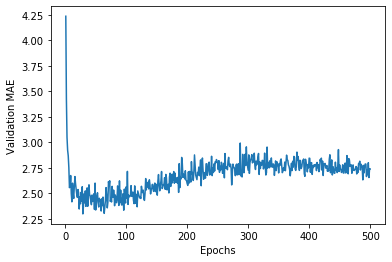

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

我們這張圖一開始的變化過大，中間過程又上上下下，我們很難看出個所以然來，因此我們對數據進行兩項處來更好呈現握們數據 ： 
* 刪除前 10 筆的 data
* 對數據進行 **指數移動平均值（EMA）** 計算讓曲線平滑一點,讓每筆資料會受到鄰近時間點的數據影響，越靠近的影響越大，越遠的影響越小  

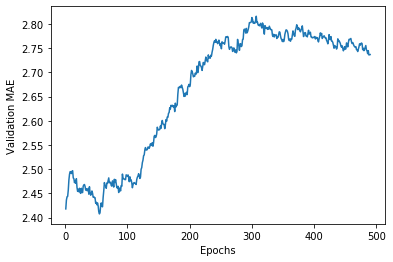

In [25]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

由上圖我們可以知道，最佳的 Validation 差不多是在第 80 個 epoch 的時候，那我們就可以針對這個資訊來訓練我們的模型

### **Step 5: Final train**

In [28]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_labels,
          epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_labels)

102/102 [==============================] - 0s 858us/step


In [32]:
print(f'MSE score :{test_mse_score} ; MAE score {test_mae_score}')

MSE score :18.721341600605086 ; MAE score 2.5861641472461177
